<a href="https://colab.research.google.com/github/StarDylan/FlowMatching/blob/main/Autoencoder_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages, Import Libraries

In [1]:
!pip install torchcfm
!pip install datashader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%load_ext autoreload
%autoreload 2
import os

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
import numpy as np

import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import torchdiffeq
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

savedir = "models/cond_mnist"
os.makedirs(savedir, exist_ok=True)

# Config

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 10

mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=mnist_transform,
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.84MB/s]


In [5]:
autoencoder_batch_size = 32

test_dataset = datasets.MNIST(
    "../data",
    train=False,
    download=True,
    transform=mnist_transform,
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=autoencoder_batch_size, shuffle=True, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=autoencoder_batch_size, shuffle=False
)

# Autoencoder from [wikibook/keras](https://github.com/wikibook/keras/blob/master/chapter3-autoencoders/autoencoder-2dim-mnist-3.2.2.py)

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # -> (32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> (64, 7, 7)
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 7 * 7, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (32, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (1, 28, 28)
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 64, 7, 7)
        x = self.deconv(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


# Train the Autoencoder

In [7]:
train_losses = []

latent_dim = 2
autoencoder = Autoencoder(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

if os.path.exists(os.path.join(savedir, f"mnist_autoencoder_latent={latent_dim}.pt")) and False:
    autoencoder.load_state_dict(torch.load(os.path.join(savedir, f"mnist_autoencoder_latent={latent_dim}.pt")))

else:
  n_epochs = 20
  for epoch in range(n_epochs):
      autoencoder.train()
      running_loss = 0
      for i, batch in enumerate(train_loader):
          imgs, _ = batch
          imgs = imgs.to(device)

          optimizer.zero_grad()
          outputs = autoencoder(imgs)
          loss = criterion(outputs, imgs)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          print(f"\r epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="")
      avg_loss = running_loss / len(train_loader)
      train_losses.append(avg_loss)
      print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss:.4f}")
  torch.save(autoencoder.state_dict(), os.path.join(savedir, f"mnist_autoencoder_latent={latent_dim}.pt"))

 epoch: 0, steps: 1874, loss: 0.1864Epoch [1/20], Loss: 400.3239
 epoch: 1, steps: 1874, loss: 0.1706Epoch [2/20], Loss: 356.3686
 epoch: 2, steps: 1874, loss: 0.1965Epoch [3/20], Loss: 344.9668
 epoch: 3, steps: 1874, loss: 0.1715Epoch [4/20], Loss: 336.7003
 epoch: 4, steps: 1874, loss: 0.1767Epoch [5/20], Loss: 331.6101
 epoch: 5, steps: 1874, loss: 0.1781Epoch [6/20], Loss: 328.3314
 epoch: 6, steps: 1874, loss: 0.1661Epoch [7/20], Loss: 325.5912
 epoch: 7, steps: 1874, loss: 0.1616Epoch [8/20], Loss: 323.5715
 epoch: 8, steps: 1874, loss: 0.1686Epoch [9/20], Loss: 321.9888
 epoch: 9, steps: 1874, loss: 0.1732Epoch [10/20], Loss: 320.7203
 epoch: 10, steps: 1874, loss: 0.1366Epoch [11/20], Loss: 319.3114
 epoch: 11, steps: 1874, loss: 0.1775Epoch [12/20], Loss: 318.4117
 epoch: 12, steps: 1874, loss: 0.1517Epoch [13/20], Loss: 317.3722
 epoch: 13, steps: 1874, loss: 0.1615Epoch [14/20], Loss: 316.7661
 epoch: 14, steps: 1874, loss: 0.1705Epoch [15/20], Loss: 316.1150
 epoch: 15, st

# Evaluating the autoencoder on different metrics

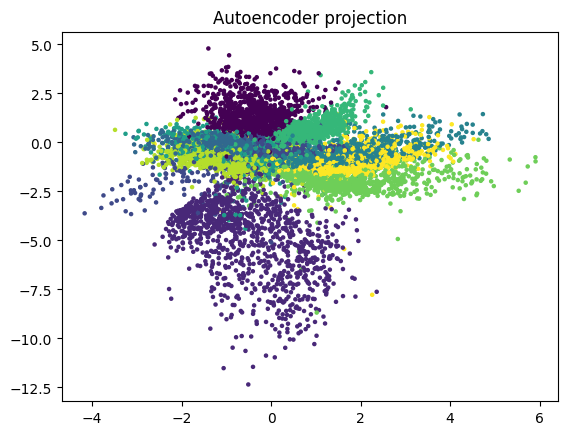

{'method': 'Autoencoder',
 'reconstruction_mse': np.float32(0.15154357),
 'reconstruction_ssim': None,
 'silhouette': np.float32(0.08557345)}

In [9]:
autoencoder.encoder.eval()
zs = []
labels = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        z = autoencoder.encoder(x)
        zs.append(z.cpu())
        labels.append(y)
zs = torch.cat(zs)
labels = torch.cat(labels)

plt.scatter(x=zs[:, 0],
            y=zs[:, 1],
            s=5,
            c=labels)
plt.title("Autoencoder projection")
plt.show()

autoencoder.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)[:1000]
    outputs = autoencoder(imgs)

imgs = imgs.cpu().numpy()
outputs = outputs.cpu().numpy()
comparison = np.concatenate([imgs, outputs])

eval_metrics = {
  "method": "Autoencoder",

  # get the mean squared error of the image reconstructions
  "reconstruction_mse": ((imgs - outputs)**2).mean(),

  # # get the structural similarity of the image reconstructions
  "reconstruction_ssim": None,
  # "reconstruction_ssim": ssim(imgs,
  #                             outputs,
  #                             data_range=outputs.max() - outputs.min(),
  #                             win_size=7),

  # get the silhouette score of the dimensionality-reduced clusters
  "silhouette": silhouette_score(zs[:1000], labels[:1000])
}
eval_metrics